In [91]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import time

In [2]:
file_train_text = "../../data/training_text/training_text"
file_train_variant = "../../data/training_variants/training_variants"

In [203]:
train_text = pd.read_csv(file_train_text, sep = '\|\|')
train_text.index.name = "ID"
train_text.columns = ["Text"]

train_variant = pd.read_csv(file_train_variant)
train_variant.set_index("ID",inplace = True)

/home/ragou/.local/lib/python3.8/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


In [4]:
train_variant[train_variant["Variation"].isin(["C396R", "H398Q", "Y371H", "K382E", "C381A"])]

,Gene,Variation,Class
ID,,,
8,CBL,Y371H,4
11,CBL,K382E,4
13,CBL,C381A,4
21,CBL,C396R,4


In [5]:
train_variant[train_variant["Variation"] == "Q249E"]

,Gene,Variation,Class
ID,,,
2,CBL,Q249E,2


In [6]:
train_text.loc[[6],]

,Text
ID,
6,Oncogenic mutations in the monomeric Casitas B...


In [7]:
gene_count = train_variant["Gene"].value_counts().loc[lambda x : x > 100].to_dict()

In [8]:
gene_class = train_variant[train_variant["Gene"].isin(gene_count.keys())]

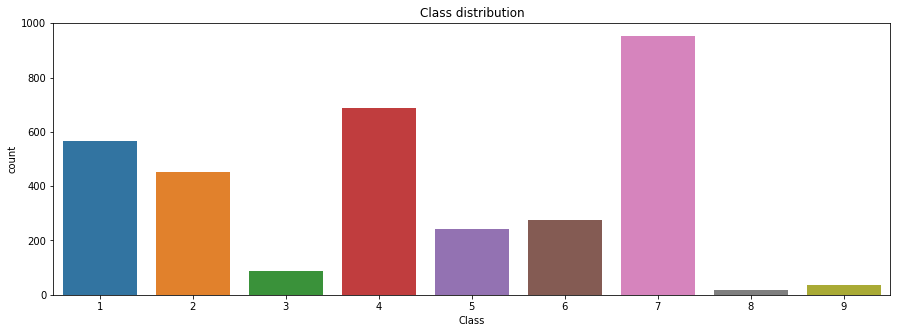

In [9]:
plt.figure(figsize=(15,5))
sns.countplot(x = train_variant["Class"])
plt.title("Class distribution")
plt.show()

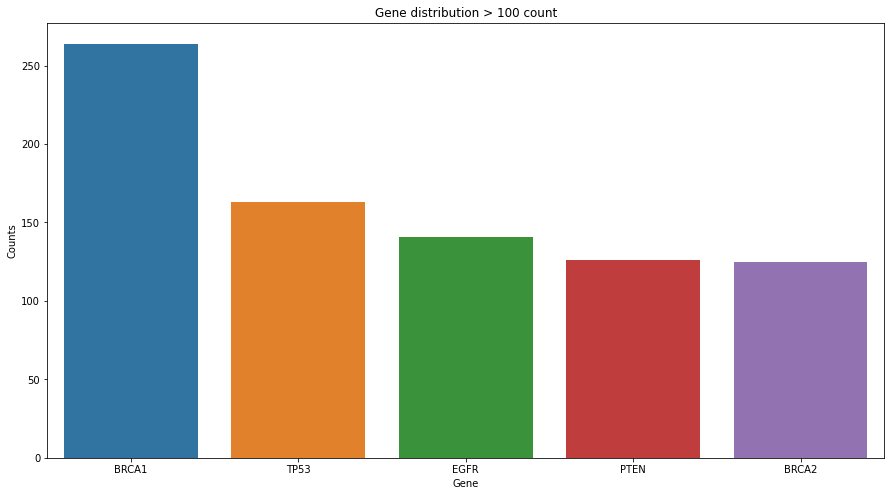

In [10]:
plt.figure(figsize=(15,8))

sns.barplot( x = list(gene_count.keys()), y = list(gene_count.values()))
plt.title("Gene distribution > 100 count")
plt.ylabel("Counts")
plt.xlabel("Gene")

plt.show()

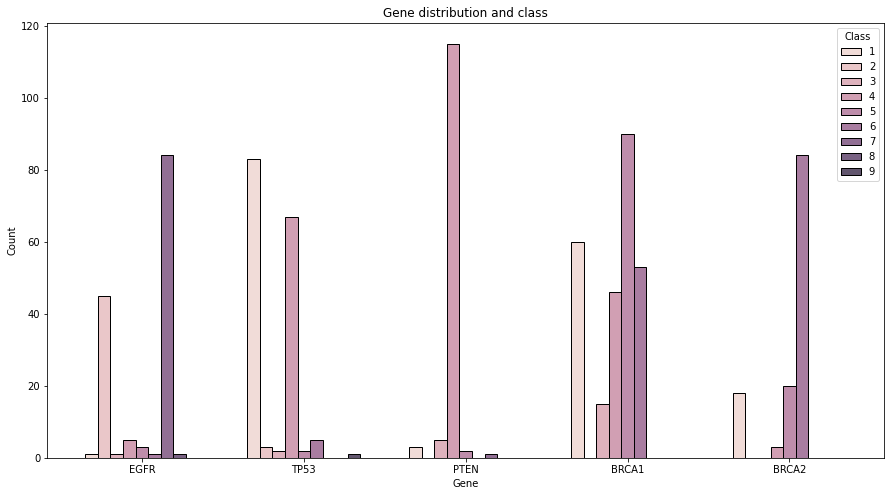

In [11]:
plt.figure(figsize=(15,8))
sns.histplot(data=train_variant[train_variant["Gene"].isin(gene_count.keys())],
             x="Gene", hue="Class", multiple="dodge", shrink=.7)
plt.title("Gene distribution and class")
plt.show()

In [12]:
train_variant.head(5)

,Gene,Variation,Class
ID,,,
0,FAM58A,Truncating Mutations,1
1,CBL,W802*,2
2,CBL,Q249E,2
3,CBL,N454D,3
4,CBL,L399V,4


In [200]:
train_variant[train_variant["Gene"] == "RAD51"]

,Gene,Variation,Class
ID,,,


In [7]:
amino_acid_dict = {'C' : 'CYS', 'D' : 'ASP', 'S' : 'SER', 'Q' : 'GLN', 'K' : 'LYS',
    'I' : 'ILE', 'P' : 'PRO', 'T' : 'THR', 'F' : 'PHE', 'N' : 'ASN', 
    'G' : 'GLY', 'H' : 'HIS', 'L' : 'LEU', 'R' : 'ARG', 'W' : 'TRP', 
    'A' : 'ALA', 'V' : 'VAL', 'E' : 'GLU', 'Y' : 'TYR', 'M' : 'MET'}

# Fonction pour la selection

## clean_text
Nettoie l'article, lower puis enlève les points qui pourrait nuire à la detection des phrases, (comme les "...", ou "fig.A")


## find_match
Va détecter la phrase qui contient le mot, puis prend 1 phrase avant et après (au total 3 phrase) (voir diapo)

In [8]:
def amino_three(amino):
    return amino_acid_dict[amino]
    
def decompose_variation(variation):
    decompose_aa_pos_aa = re.compile("([a-z]{1,})(\d+)([a-z]{1,})")
    list_variation = decompose_aa_pos_aa.search(variation)
    if list_variation:
        aa1 = list_variation.group(1)
        aa2 = list_variation.group(3)

        if len(aa1) + len(aa2) == 2:
            amino1 = amino_acid_dict[aa1.upper()].lower()
            position = list_variation.group(2)
            amino2 = amino_acid_dict[aa2.upper()].lower()
            return [amino1,position,amino2]
    return False

def decompose_fusion(variation):
    decompose_g1_g2_fusion = re.compile("(\w+)\s?(\?|-)\s?(\w+)\? fusion")
    list_variation = decompose_g1_g2_fusion.search(variation)
    if list_variation:
        gene1 = list_variation.group(1)
        gene2 = list_variation.group(3)
        print(gene1,gene2,variation, list_variation.group(0))
        return "(" + gene1 + "|" + gene2 + ")"
    return False
        
    

In [212]:
def clean_text(article):
    dot3 = re.compile("[\.]{2,}")
    fig = re.compile("fig[s]?\.")
    decimal = re.compile("\d+\.\d+")    
    etal = re.compile("et al\.")
    ie = re.compile("i\.e\.")
    inc = re.compile("inc\.")
    mutation_point = re.compile("[p|c]\.")
    
    clean_article = article.lower()
    clean_article = dot3.sub(".", clean_article)
    clean_article = fig.sub("", clean_article)
    clean_article = decimal.sub("", clean_article)
    clean_article = etal.sub("", clean_article)
    clean_article = ie.sub("", clean_article)    
    clean_article = inc.sub("", clean_article)    
    clean_article = mutation_point.sub("", clean_article)    
    
    
    return clean_article

def join_tuple_string(strings_tuple):
    return ' '.join(strings_tuple)

def find_match(text, word):
    clean = clean_text(text)
    word = word.lower()
    target_sentence = "([^.]*{}[^.]*\.)".format(word)
    before_after_target = "([^.]*\.){0,1}"    
    match_exp = re.compile(before_after_target + target_sentence + before_after_target)
    match_text = match_exp.findall(clean)
    final_match = "".join(list(map(join_tuple_string, match_text)))
    return final_match

def extract_match(line):
    # Mettre celui qui consomme le moins en 1er --> ceux qui sont facile à faire sans trop de calcul !
    # 1er : best match
    # 2e ?
    
    
    # Cleaning text     
    text = clean_text(line["Text"])
    variation = line["Variation"].lower()
    gene = line["Gene"].lower()
    print(line.name)
    # Try first match with inital variation value
    # Quality score = 1 
    initial_match = find_match(text, variation)    
    if len(initial_match) != 0:
        print("First match ! ", variation)
        return initial_match, 1
    

    # Fusion of two genes
    # Quality score = 2
    if "fusion" in variation:
        fusion_gene = decompose_fusion(variation)
        if fusion_gene:
            match_fusion_gene = find_match(text, fusion_gene)
            if len(match_fusion_gene) != 0:
                print("Fusion gene1 | gene2", variation)
                return match_fusion_gene, 2

        # Try to match the word fusion at least..
        # Quality score 4 (bad)
        match_fusion = find_match(text,"fusion")
        if len(match_fusion) != 0:
            print("FUSION", variation)
            return match_fusion, 4
        
    aa_pos_aa = decompose_variation(variation)
    if aa_pos_aa :
        if len(aa_pos_aa) == 3:
            # If we success to split variation in 3 group --> aa1 pos aa2
            # Second try without the last amino acid --> y371
            match_variation_aa_pos = find_match(text, variation[:-1])
            if len(match_variation_aa_pos) != 0:
                print("y371 aa_pos", variation)
                
                return match_variation_aa_pos, 2

            # Third try with 3 letter code of amino acid --> tyr371ser
            match_aa_pos_aa = find_match(text, "".join(aa_pos_aa))
            if len(match_aa_pos_aa) != 0:
                print("aa_pos_aa", variation)
                return match_aa_pos_aa, 1.1
            
            # Try with 3 letter code without the last aa --> tyr371
            match_aa_pos = find_match(text, aa_pos_aa[0] + aa_pos_aa[1])
            if len(match_aa_pos) != 0:
                print("aa_pos", variation)
                
                return match_aa_pos,2
            
            # Match position only --> 371
            match_pos = find_match(text, aa_pos_aa[1])
            if len(match_pos) != 0:
                print("pos", variation)
                
                return match_pos,4
            
            # Match position around the real position --> 370 - 379
            match_pos_weak = find_match(text, aa_pos_aa[1][:-1] + "[0-9]")
            if len(match_pos_weak) != 0:
                print("pos weak", variation)
                
                return match_pos_weak,5
            
            
            
    return [],0



# Exemple à la main juste pour tester

In [15]:
word_to_search = "FAM58A"

In [16]:
article = train_text.loc[0].values[0]

In [17]:
article.count(word_to_search)

34

In [32]:
clean_match = find_match(article, word_to_search)

In [33]:
print("Before selection : total lenght {} and {} occurences of the word {}".format(
    len(article),article.count(word_to_search) , word_to_search))

print("After selection :  total lenght {} and {} occurences of the word {}".format(
    len(clean_match),clean_match.count(word_to_search.lower()), word_to_search))

Before selection : total lenght 39672 and 34 occurences of the word FAM58A
After selection :  total lenght 9214 and 34 occurences of the word FAM58A


In [235]:
concatenate_data = pd.merge(train_variant, train_text, on="ID").dropna()
concatenate_data

,Gene,Variation,Class,Text
ID,,,,
0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...
...,...,...,...,...
3316,RUNX1,D171N,4,Introduction Myelodysplastic syndromes (MDS) ...
3317,RUNX1,A122*,1,Introduction Myelodysplastic syndromes (MDS) ...
3318,RUNX1,Fusions,1,The Runt-related transcription factor 1 gene (...


In [236]:
concatenate_data["Text"] = concatenate_data.apply(lambda line: clean_text(line["Text"]), axis = 1)

In [238]:
concatenate_data["Variation"] = train_variant["Variation"].apply(lambda line: line.lower())

In [240]:
concatenate_data

,Gene,Variation,Class,Text
ID,,,,
0,FAM58A,truncating mutations,1,cyclin-dependent kinases (cdks) regulate a var...
1,CBL,w802*,2,abstract background non-small cell lung canc...
2,CBL,q249e,2,abstract background non-small cell lung canc...
3,CBL,n454d,3,recent evidence has demonstrated that acquired...
4,CBL,l399v,4,oncogenic mutations in the monomeric casitas b...
...,...,...,...,...
3316,RUNX1,d171n,4,introduction myelodysplastic syndromes (mds) ...
3317,RUNX1,a122*,1,introduction myelodysplastic syndromes (mds) ...
3318,RUNX1,fusions,1,the runt-related transcription factor 1 gene (...


# Explications du problème
Fonction poubelle juste pour voir ceux qui sont pas détectable --> len(match) == 0

Si ils sont pas détectable, c'est que le nom donné pour leurs variation sont pas dans l'article, donc je vérfie à la main sur le site https://regex101.com/r/lvQZIf/1 qui sert à visualiser les expressions régulières.
En copiant collant tout l'article, je regarde comment je peux détecter la variation avec un autre nom ducoup, comme le nom de base ne marche pas.

Par exemple Id = 19, y371s n'est pas dans l'article mais il y est sous la forme tyr371ser.

Cet regexpr ne marche pas (le texte est en minuscule) -> `([^.]*\.){0,1}([^.]*y371s[^.]*\.)([^.]*\.){0,2}`

Mais celle la marchera -> `([^.]*\.){0,1}([^.]*tyr371ser[^.]*\.)([^.]*\.){0,2}` (ça donne 3 match sur le site pour l'article id = 19)

(pour les regex, il faut juste changer le nom au milieu après `*` et avant `[^.]`)

Autre exemple, ID = 102, mutation r922* qui n'est mentionné sous aucunes formes, ni même la position 922. Mais, il y a des mots qui peuvent faire penser à cette mutation du genre "nonsense mutations" car l'étoile (\*) veut dire que r922 est devenu un codon stop, donc c'est une mutation non sens. Faudrait voir si je peux convertir ces mutations en mot pour faciliter la détection, ou utiliser un champ lexical.


Donc là, j'essaie de faire plus ou moins au cas par cas (pas tous, y en a 880...) pour déterminer des groupes de variations indétectable pour revoir la détection.
Par exemple, pour les variations de type `y371s`, je peux prendre `y371`, ou tout simplement `371` qui peuvent détecter la variation dans certain cas.


Par contre, pour ceux où y a vraiment pas d'infos dans l'article avec la variation, du genre `t1365m` ID = 44; je sais pas quoi faire d'eux :)
Car la position 1365 n'est même pas mentionné dans l'article, donc je vois pas comment détecter les infos liées à cette mutation...

Soit je garde l'article entier, soit je prend le nom du gène pour la détection, mais le pb avec ça, c'est que ducoup tout ceux qui sont indétectables de ce gène là, auront les mêmes lignes de détecté car je détecterai uniquement en utilisant le nom du gène, donc y aura pas de différences entre eux même si la variation diffère.




## Ne lance pas la cellule juste en bas, ça prend un certain temps et de toute façon, tu as déjà la sortie avec tout ceux qui ne marchent pas.

La sortie est de la forme : 
`variation | id | len(article_original) | len(match)`

Certaines variations sont des mots complets du genre `truncating mutations`, un peu relou pour la détection, ce qu'on pourrait faire, c'est utiliser des mots qui ressemble à truncating grace à des méthodes de traitements de texte qui va prendre que le préfix par exemple et automatiser ça pour les mots

In [216]:
def check_line(x):
    extract = extract_match(x)
    score = extract[1]
    if score == 0:
        print(x["Variation"].lower(), x.name, len(x["Text"]))

        
#concatenate_data.apply(lambda x : check_line(x) , axis = 1)

# Variable ID pour faciliter le print des deux cellules suivantes pour choper le text, la variation et le gene d'un ID et les copier coller sur le site regex

Pour la détection, je teste juste avec le nom de la variation, puis vraiment si y a rien, je regarde du coté du nom du gène

In [193]:
ID = 28    

In [242]:
concatenate_data.loc[ID,"Text"]

"sequencing studies have identified many recurrent coding mutations in human cancer genes; however, highly recurrent mutations involving regulatory regions have rarely been observed. here we describe two independent mutations within the tert core promoter that, when taken together, were observed in 71% (50 of 70) of melanomas and generate de novo consensus ets binding motifs. reporter assays showed that these mutations increase transcriptional activity from the tert promoter by 2–4-fold. examination of cancer cell lines derived from diverse tumor types revealed the same mutations in 16% (24 of 150) of cases, with preliminary evidence of elevated frequency in bladder and hepatocellular cancer cells. thus, somatic mutations in regulatory regions of the genome may represent an important tumorigenic mechanism.  systematic characterization of human cancer genomes has led to the discovery of a wide range of mutated genes that contribute to tumor development and progression. most of the somat

In [245]:
print(concatenate_data.loc[ID,"Variation"],
concatenate_data.loc[ID,"Gene"].lower())

c228t tert


In [246]:
start = time.time()
clean_match_data = concatenate_data.apply(lambda x: extract_match(x), axis = 1)
clean_match = pd.DataFrame(list(clean_match_data), columns = ["Text","Score"], index = clean_match_data.index)
print("done in {} s".format(time.time() - start))

0
1
First match !  w802*
2
First match !  q249e
3
First match !  n454d
4
First match !  l399v
5
First match !  v391i
6
First match !  v430m
7
First match !  deletion
8
First match !  y371h
9
First match !  c384r
10
First match !  p395a
11
First match !  k382e
12
First match !  r420q
13
First match !  c381a
14
First match !  p428l
15
First match !  d390y
16
17
First match !  q367p
18
First match !  m374v
19
aa_pos_aa y371s
20
First match !  h94y
21
First match !  c396r
22
First match !  g375p
23
First match !  s376f
24
First match !  p417a
25
First match !  h398y
26
First match !  s2g
27
First match !  y846c
28
First match !  c228t
29
First match !  h412y
30
First match !  h876q
31
First match !  promoter mutations
32
First match !  p704s
33
First match !  amplification
34
First match !  c250t
35
First match !  g1809r
36
First match !  g1809k
37
First match !  d1709e
38
First match !  d1709a
39
First match !  e1705a
40
First match !  d1810a
41
First match !  truncating mutations
42
Firs

pos v274f
387
First match !  r175c
388
First match !  r248w
389
First match !  s121a
390
First match !  y220s
391
First match !  p153h
392
First match !  r181c
393
First match !  r337c
394
First match !  k120n
395
First match !  g245d
396
First match !  r175h
397
First match !  r181l
398
First match !  g244s
399
pos s240r
400
First match !  r273c
401
First match !  e221q
402
First match !  q331h
403
First match !  y220c
404
First match !  r342p
405
First match !  c242f
406
First match !  c242s
407
y371 aa_pos c135s
408
First match !  m237k
409
aa_pos v197l
410
First match !  s121c
411
First match !  s241f
412
413
First match !  r248k
414
First match !  h214r
415
First match !  l330r
416
pos weak p151s
417
First match !  truncating mutations
418
First match !  r110l
419
First match !  c176f
420
First match !  h179y
421
First match !  c277r
422
First match !  l344r
423
First match !  r267q
424
First match !  r156h
425
First match !  d186a
426
First match !  c275s
427
First match !  e285k

First match !  l726i
742
First match !  h878y
743
First match !  exon 20 insertions
744
First match !  amplification
745
First match !  l755s
746
First match !  d821n
747
First match !  g309a
748
aa_pos_aa e265k
749
First match !  d769y
750
First match !  t798i
751
First match !  l755p
752
y371 aa_pos y1248f
753
First match !  p780l
754
First match !  v777l
755
First match !  s783p
756
First match !  d769a
757
First match !  c311r
758
759
First match !  d277h
760
First match !  r143q
761
First match !  g309e
762
First match !  e321g
763
First match !  l726f
764
First match !  v777m
765
First match !  y803n
766
First match !  n857s
767
First match !  d845a
768
769
First match !  s310y
770
First match !  v794m
771
772
First match !  s846i
773
First match !  a1131t
774
First match !  g284r
775
First match !  p262h
776
First match !  v714m
777
First match !  t389k
778
First match !  amplification
779
First match !  q809r
780
First match !  r669c
781
First match !  a232v
782
First match !  

1094
1095
First match !  e1286v
1096
First match !  t779fs
1097
First match !  truncating mutations
1098
First match !  deletion
1099
First match !  a95d
1100
First match !  e685v
1101
First match !  c91s
1102
First match !  truncating mutations
1103
First match !  f170i
1104
First match !  i47f
1105
First match !  c91a
1106
First match !  f81v
1107
First match !  deletion
1108
First match !  s858r
1110
First match !  truncating mutations
1111
First match !  h492r
1112
First match !  y510c
1113
First match !  deletion
1114
First match !  l274p
1115
First match !  w183a
1116
First match !  l210r
1117
1118
1119
First match !  r970c
1120
y371 aa_pos y1003c
1121
1122
First match !  f1200i
1123
First match !  n375s
1124
aa_pos v1092i
1125
First match !  y1230c
1126
First match !  y1003f
1127
First match !  amplification
1128
1129
1130
First match !  d1010h
1131
1132
1133
First match !  overexpression
1134
First match !  y1003*
1135
First match !  y1235d
1136
1137
First match !  d1010y
1138


First match !  f102c
1449
First match !  m117i
1450
1451
First match !  r251q
1452
First match !  k517r
1453
First match !  e731k
1454
First match !  y375c
1455
First match !  k659n
1456
First match !  fusions
1457
First match !  t730s
1458
First match !  fgfr2-mgea5 fusion
1459
First match !  v755i
1460
First match !  g271e
1461
First match !  l770v
1462
First match !  r203c
1463
pos e565g
1464
First match !  fgfr2-ahcyl1 fusion
1465
First match !  a648t
1466
pos weak n549s
1467
First match !  p253r
1468
First match !  g701s
1469
First match !  t341p
1470
FUSION fgfr2?pphln1 fusion
1471
First match !  n549k
1472
First match !  s252w
1473
First match !  fgfr2-bicc1 fusion
1474
First match !  v248d
1475
First match !  k526e
1476
First match !  l617f
1477
First match !  i642v
1478
pos weak m535i
1479
pos weak k525e
1480
First match !  e636k
1481
FUSION fgfr2-tacc3 fusion
1482
FUSION fgfr2-kiaa1967 fusion
1483
1484
First match !  c278f
1485
First match !  a389t
1486
pos weak l617m
1487
14

y371 aa_pos s214t
1805
First match !  q347_a348del
1806
First match !  f351l
1807
First match !  s214c
1808
First match !  g322s
1809
First match !  t37a
1810
First match !  g17v
1811
aa_pos_aa g17e
1812
aa_pos_aa g14v
1813
First match !  e40q
1814
aa_pos_aa l57v
1815
First match !  r5q
1816
1817
First match !  t19n
1818
First match !  y42c
1819
First match !  e40t
1820
First match !  overexpression
1821
First match !  e40l
1822
First match !  g17a
1823
First match !  y34c
1824
First match !  e40w
1825
First match !  e40n
1826
1827
First match !  w257g
1828
y371 aa_pos s256w
1829
pos p179r
1830
aa_pos r183p
1831
First match !  r182w
1832
pos r258h
1833
First match !  s256f
1834
pos r258c
1835
pos p179l
1836
aa_pos r183g
1837
y371 aa_pos w257c
1838
aa_pos r183q
1839
First match !  deletion
1840
First match !  truncating mutations
1841
First match !  r1625c
1842
First match !  m1255i
1843
First match !  a1374v
1844
First match !  g1125a
1845
First match !  h114y
1846
First match !  p186s

First match !  c124s
2151
First match !  l112r
2152
First match !  a34d
2153
First match !  e157g
2154
First match !  d107y
2155
First match !  a121p
2156
First match !  h118p
2157
First match !  a121v
2158
First match !  c136y
2159
First match !  r130*
2160
First match !  t401i
2161
First match !  l181p
2162
First match !  l112p
2163
First match !  g129r
2164
First match !  y68h
2165
pos p38l
2166
First match !  y174n
2167
First match !  t131l
2168
First match !  r15s
2169
First match !  y155c
2170
First match !  s227f
2171
First match !  c71y
2172
First match !  k125r
2173
First match !  s10n
2174
First match !  r173c
2175
First match !  d162h
2176
2177
First match !  f347l
2178
First match !  p95s
2179
First match !  m199del
2180
First match !  n276s
2181
First match !  t131a
2182
First match !  s362l
2183
y371 aa_pos v217d
2184
First match !  g129a
2185
First match !  t167a
2186
First match !  a126g
2187
First match !  g165e
2188
First match !  p169h
2189
First match !  n48k
2190
F

First match !  r1699l
2476
First match !  v1804a
2477
First match !  e23fs
2478
pos weak f1734s
2479
First match !  c61g
2480
First match !  d245v
2481
First match !  p142h
2482
pos l1705p
2483
First match !  h1686r
2484
pos weak p1776s
2485
First match !  m1783t
2486
pos weak s1841r
2487
First match !  v1534m
2488
First match !  w1782c
2489
First match !  g1706a
2490
First match !  g1788v
2491
First match !  w1837g
2492
First match !  a1708e
2493
First match !  s1512i
2494
y371 aa_pos m1783i
2495
2496
y371 aa_pos m1783l
2497
First match !  g1706e
2498
First match !  r496c
2499
First match !  s153r
2500
First match !  n810y
2501
First match !  k1702e
2502
pos weak a1789s
2503
First match !  r866c
2504
pos weak v11a
2505
First match !  d1739v
2506
y371 aa_pos m1775e
2507
First match !  d67y
2508
First match !  d1344h
2509
First match !  v271l
2510
pos weak s1841n
2511
y371 aa_pos f1761s
2512
First match !  e1586g
2513
First match !  s1841a
2514
y371 aa_pos i89n
2515
First match !  l82p


First match !  p655r
2830
First match !  l1019v
2831
First match !  r2888c
2832
2833
2834
First match !  k2950n
2835
First match !  r2784w
2836
First match !  i2627f
2837
2838
First match !  d2312v
2839
First match !  d2723h
2840
First match !  deletion
2841
2842
First match !  v2908g
2843
pos r18h
2844
aa_pos_aa s196n
2845
First match !  a1170v
2846
First match !  r2336h
2847
First match !  d806h
2848
pos weak v1643a
2849
First match !  h1966y
2850
First match !  t630i
2851
First match !  e2856a
2852
First match !  s1733f
2853
First match !  e462g
2854
First match !  i1349t
2855
First match !  d3095e
2856
First match !  r2973c
2857
First match !  d935n
2858
First match !  d2665g
2859
First match !  d3170g
2860
aa_pos_aa r2602t
2861
First match !  r2842c
2862
First match !  c554w
2863
First match !  n1228d
2864
First match !  v3079i
2865
First match !  h1918y
2866
aa_pos_aa l209f
2867
First match !  g602r
2868
First match !  i2285v
2869
pos weak s326r
2870
First match !  v2969m
2871
Fi

First match !  r661w
3207
First match !  w563l
3208
First match !  c712r
3209
3210
First match !  s567l
3211
First match !  c706f
3212
First match !  truncating mutations
3213
First match !  deletion
3214
First match !  amplification
3215
FUSION tpr-ntrk1 fusion
3216
First match !  v710a
3217
pos r342w
3218
First match !  fusions
3219
First match !  bcan-ntrk1 fusion
3220
First match !  nfasc-ntrk1 fusion
3221
First match !  trkaiii splice variant
3222
pos r342q
3223
FUSION delta-ntrk1 fusion
3224
First match !  cd74-ntrk1 fusion
3225
First match !  tpm3-ntrk1 fusion
3226
FUSION chtop-ntrk1 fusion
3227
First match !  amplification
3228
FUSION tfg-ntrk1 fusion
3229
First match !  lmna-ntrk1 fusion
3230
FUSION mprip-ntrk1 fusion
3231
First match !  m713i
3232
First match !  fusions
3233
First match !  r715g
3234
First match !  etv6-ntrk3 fusion
3235
First match !  btbd1-ntrk3 fusion
3236
First match !  fusions
3237
FUSION cpeb1-ntrk3 fusion
3238
First match !  g623r
3239
First match !  d

In [247]:
clean_match_data

ID
0                                                 ([], 0)
1       ( the c-cbl loh also positively correlated wit...
2       ( the c-cbl loh also positively correlated wit...
3       ( most of the changes were novel, although 4 c...
4       ( all mutations from the second group were pre...
                              ...                        
3316    (21⇓⇓⇓⇓⇓⇓⇓–29 the vast majority of aml1 mutati...
3317                                              ([], 0)
3318    ( lpxn is preferentially expressed in hematopo...
3319    () conversely, mutations mapping to the first ...
3320    ( mutation analysis in fpd/aml pedigrees. elec...
Length: 3316, dtype: object

In [248]:
clean_match[clean_match["Score"] == 0]

,Text,Score
ID,,
0,[],0.0
16,[],0.0
46,[],0.0
61,[],0.0
71,[],0.0
...,...,...
3263,[],0.0
3298,[],0.0
3305,[],0.0


In [262]:
clean_match.index.name = "ID"
new_data = pd.merge(concatenate_data,clean_match, on = "ID")

In [250]:
new_data[new_data["Score"] == 1]

,Gene,Variation,Class,Text,Score
ID,,,,,
1,CBL,W802*,2,the c-cbl loh also positively correlated with...,1.0
2,CBL,Q249E,2,the c-cbl loh also positively correlated with...,1.0
3,CBL,N454D,3,"most of the changes were novel, although 4 ca...",1.0
4,CBL,L399V,4,all mutations from the second group were pred...,1.0
5,CBL,V391I,4,all mutations from the second group were pred...,1.0
...,...,...,...,...,...
3315,RUNX1,RUNX1-RUNX1T1 Fusion,4,this truncated protein contained the rhd but ...,1.0
3316,RUNX1,D171N,4,21⇓⇓⇓⇓⇓⇓⇓–29 the vast majority of aml1 mutatio...,1.0
3318,RUNX1,Fusions,1,lpxn is preferentially expressed in hematopoi...,1.0


In [66]:
new_data[new_data["Gene"] == "RUNX1"]

,Gene,Variation,Class,Text,Score
ID,,,,,
3297,RUNX1,R177*,4,the mutation was present in all affected indi...,1.0
3298,RUNX1,Y113*,4,21⇓⇓⇓⇓⇓⇓⇓–29 the vast majority of aml1 mutatio...,5.0
3299,RUNX1,R139G,4,the mutation was present in all affected indi...,1.0
3300,RUNX1,K83N,4,[],0.0
3301,RUNX1,R177Q,4,because of his history of thrombocytopenia s...,1.0
3302,RUNX1,R166Q,4,[],0.0
3303,RUNX1,P173S,4,familial platelet disorder with propensity to...,1.0
3304,RUNX1,R201Q,4,"to explore the underlying mechanisms for bc, ...",1.0
3305,RUNX1,S70fsX93,4,com/reviews/cancer © 2015 macmillan publishers...,1.0


In [74]:
new_data.loc[3315,"Text"]

' mutation analysis in fpd/aml pedigrees. electropherograms from affected and control individuals showing the a>g substitution leading to the k83e missense mutation in pedigree 1 (a), the c>a substitution resulting in a nonsense mutation y260x in pedigree 3 (b), and the deletion of an a at the +3 position of the spldonor sof intron 4 in pedigree 2 (ivs4\u2009+\u20093dela, c).  arrows indicate the point of the mutations. extended haplotype analysis of each family indicated an approximate 3 megabase common nonrecombinant interval on human chromosome 21q containing runx1 in affected individuals. pedigree 1 showed an a>g substitution in exon 3 resulting in a missense mutation, k83e (figure 2a).  the mutation segregates with the disorder in the family and was absent in 188 unrelated control chromosomes. the mutation segregated with the dse in all family members tested. effects of runx1 fpd/aml mutations on dna binding and heterodization activities of the runt domainwe exam the function of t

In [76]:
extract_match(new_data.loc[3315,])

3315


([], 0)

In [251]:
RUNX1 = concatenate_data[concatenate_data["Gene"] == "TERT"].apply(lambda x: extract_match(x), axis = 1)

27
First match !  y846c
28
First match !  c228t
29
First match !  h412y
30
First match !  h876q
31
First match !  promoter mutations
32
First match !  p704s
33
First match !  amplification
34
First match !  c250t


In [252]:
RUNX1_dtf = pd.DataFrame(list(RUNX1), columns = ["Text","Score"], index = RUNX1.index)

In [253]:
RUNX1

ID
27    ( in one case the proband is homozygous for a ...
28    ( the average sequence coverage at the tert pr...
29    ( both families contain compound heterozygotes...
30    ( in one case the proband is homozygous for a ...
31    ( to determine whether tumor genomes harbor re...
32    ( both families contain compound heterozygotes...
33    ( among them, acral lentiginous melanoma (alm)...
34    ( the average sequence coverage at the tert pr...
dtype: object

In [254]:
concat_RUNX1 = pd.merge(concatenate_data.loc[RUNX1_dtf.index,],RUNX1_dtf, on ="ID")

In [255]:
concat_RUNX1

,Gene,Variation,Class,Text_x,Text_y,Score
ID,,,,,,
27,TERT,y846c,4,heterozygous mutations in the telomerase compo...,in one case the proband is homozygous for a n...,1
28,TERT,c228t,7,sequencing studies have identified many recurr...,the average sequence coverage at the tert pro...,1
29,TERT,h412y,4,heterozygous mutations in the telomerase compo...,both families contain compound heterozygotes....,1
30,TERT,h876q,4,heterozygous mutations in the telomerase compo...,in one case the proband is homozygous for a n...,1
31,TERT,promoter mutations,7,sequencing studies have identified many recurr...,to determine whether tumor genomes harbor rec...,1
32,TERT,p704s,4,heterozygous mutations in the telomerase compo...,both families contain compound heterozygotes....,1
33,TERT,amplification,2,the current world health organization classifi...,"among them, acral lentiginous melanoma (alm) ...",1
34,TERT,c250t,7,sequencing studies have identified many recurr...,the average sequence coverage at the tert pro...,1


In [290]:
new_data_best_score =  new_data[new_data["Score"] == 1]

In [291]:
count_new = new_data_best_score.apply(lambda line: line["Text_y"].split(".")[0] in line["Text_x"].lower(), axis = 1)

In [292]:
new_data.loc[count_new[count_new == False].index,]

,Gene,Variation,Class,Text_x,Text_y,Score
ID,,,,,,
118,PBRM1,truncating mutations,1,screening for tumor suppressor genes in breast...,screening for tumor suppressor genes in breas...,1.0
330,ROS1,fusions,2,oncogenic gene fusions involving the 3’ region...,oncogenic gene fusions involving the 3’ regio...,1.0
670,CDKN2A,a148t,6,background: a common missense variant of the c...,background: a common missense variant of the ...,1.0
793,ERBB4,fusions,2,purpose: to identify druggable oncogenic fusio...,purpose: to identify druggable oncogenic fusi...,1.0
851,ABL1,e255k,2,the resistance to the tyrosine kinase inhibito...,the resistance to the tyrosine kinase inhibit...,1.0
962,ESR1,fusions,2,the crucial role of recurrent gene fusions in ...,the crucial role of recurrent gene fusions in...,1.0
979,ETV1,fusions,2,gene fusions involving the erythroblast transf...,gene fusions involving the erythroblast trans...,1.0
1419,FGFR3,g375c,7,"two mutations in fgfr3, g380r and g375c are kn...","two mutations in fgfr3, g380r and g375c are k...",1.0
1424,FGFR3,a391e,7,the a391e mutation in fibroblast growth factor...,the a391e mutation in fibroblast growth facto...,1.0


In [300]:
new_data_best_score[new_data_best_score.apply(lambda line: line["Variation"] in line["Text_y"], axis = 1) == False]

,Gene,Variation,Class,Text_x,Text_y,Score
ID,,,,,,
697,CDKN2B,e35*,4,familial renal cell carcinoma (rcc) is genetic...,256g>a asp86asn (d86n) and evolutionary conse...,1.0
1074,FOXA1,s453fs*,2,characterization of the prostate cancer transc...,"together, our data suggest that aberrations i...",1.0
1302,MLH1,r100*,4,large-scale screening for germ-line mutations ...,"in f73, among 34 randomly selected mlh1 cdna ...",1.0
1326,MLH1,r487*,1,identification of a high-risk disease-causing ...,nc = mutation was not categorized as effect i...,1.0
1565,ALK,r1464*,3,"in the era of personalized medicine, understan...",in order to treat patients accordingly requir...,1.0
1695,PMS2,r802*,1,identification of a high-risk disease-causing ...,this syndrome is characterized by café-au-lai...,1.0
1897,MTOR,r2505*,3,genes encoding components of the pi3k-akt-mtor...,"however, few cancer-associated mutations have...",1.0
1953,ATM,e1978*,1,"over 1,000 reports have been published during ...",these meta-analyses included an average of s...,1.0
2548,BRCA1,y1853*,4,abstract germline mutations that inactivate th...,"among these mutations, there was an approxima...",1.0


In [340]:
new_data_best_score["Gene"].describe()

count      2435
unique      229
top       BRCA1
freq        193
Name: Gene, dtype: object

In [338]:
new_data_best_score[new_data_best_score["Gene"] == "KMT2D"]["Text_y"]

ID
115     they act as transcriptional coactivators and ...
116     in this study, we performed a mutational scre...
Name: Text_y, dtype: object

In [147]:
count = concat_RUNX1[concat_RUNX1["Score"] == 1].apply(lambda line: line["Text_y"].count(line["Variation"].lower()), axis = 1)

In [148]:
index_hacker = count[count == 0].index
index_hacker

Int64Index([], dtype='int64', name='ID')

In [341]:
new_data_best_score[new_data_best_score["Gene"] == "BRCA1"]

,Gene,Variation,Class,Text_x,Text_y,Score
ID,,,,,,
2417,BRCA1,e1735k,6,abstract the brca1 gene from individuals at ...,"published onlinefirst july 18, 2013; doi: /21...",1.0
2418,BRCA1,r1753t,4,mutations in brca1 and brca2 account for the m...,"although hr is essentially error-free, nhej i...",1.0
2419,BRCA1,c44y,4,germline mutations of the breast cancer 1 (brc...,] table 1. percentage of cells without spot i...,1.0
2424,BRCA1,g1743r,1,abstract the brca1 gene from individuals at ...,"among these six mutations, r1699w and r1699q ...",1.0
2425,BRCA1,i68k,6,germline mutations of the breast cancer 1 (brc...,"importantly, the inhibition of ubiquitin liga...",1.0
...,...,...,...,...,...,...
2674,BRCA1,m1652t,6,abstract germline mutations that inactivate th...,substitutions at position 1652 can result in ...,1.0
2675,BRCA1,e1346k,5,mutations in brca1 and brca2 account for the m...,"published onlinefirst july 18, 2013; doi: /21...",1.0
2677,BRCA1,a1843t,1,abstract the brca1 gene from individuals at ...,three of them are exposed on the face away fr...,1.0


In [342]:
import numpy as np
#CBL = train_variant[train_variant["Gene"] == "RUNX1"]
#article_cbl = train_text.loc[CBL.index,]

#CBL.to_csv("cbl.txt")
clean_TERT = new_data_best_score[new_data_best_score["Gene"] == "BRCA1"]["Text_y"]
dtf = pd.merge(pd.DataFrame(clean_TERT.index), clean_TERT, on ="ID")
dtf.columns= ["ID","Text"]

In [343]:
np.savetxt("../datas/brca1_clean_article.txt",dtf, fmt = "%d || %s", header= ",".join(dtf.columns), comments='')